In [1]:
nz=201
nx=201
h=10

nt=1000
dt=0.002
ntr=100

nsnap=51
nzsnap=249
nxsnap=249

In [2]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def flatten2D(data):
    return data.reshape(data.shape[0], data.shape[1]*data.shape[2])

def fracderivative(array,dt=dt,n=1):
    nt=array.shape[0]
    dw=1./(nt-1)/dt
    w=np.arange(-nt*dw/2,nt*dw/2-dw,dw).astype(complex)
    w=np.fft.ifftshift(w)
    #print(w.shape)
        
    spec=np.fft.fft(array)
    #print(spec.shape)
    spec=spec*(1j*w)**n
    
    return np.real(np.fft.ifft(spec))

def stack(array):
    n1,n2=array.shape
    return np.tile(np.reshape(np.sum(array,axis=1),(n1,1)),(1,n2))
    

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb(data):
    return np.imag(signal.hilbert(data,axis=0))

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))


def run(app='../../exe/FWI',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}


In [3]:
#all programs in SeisJIMU needs a setup file
!cat setup_default

MODEL_SIZE              '201   201   1'
MODEL_SPACING           '10    10    1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        vp

IS_FREESURFACE          F

FILE_DATA_PREFIX        'results_fwd/dsyn_Shot'
WEIGHTING               'polygon:wei'

IF_BLOOM                F

ACQUI_GEOMETRY          spread
FS                      '20 500 500'
FR                      '40 20  0'
DR                      '0  20  0'
NR                      100

WAVELET_TYPE            'ricker'
T0                       0.25
                       # fsz   fsx  fsy  lsz   lsx    lsy  ns
#SOURCE_LINE             '26    505  500  20    505    500  1'
                       # frz   frx  fry  lrz   lrx    lry  nr
#RECEIVER_LINE           '26    10    0   26    1990   0    100'

SCOMP                     p
RCOMP                     p #'p vz vx'

IF_HICKS		F

NT           1000
DT           0.002
FPEAK        7

PARAMETER     'vp:1500:2000'

SNAPSHOT      p

JOB           g

In [4]:
!cat wei


0    1490    #offsets of vertices
1    1.5   #time instants of vertices
5   0.1

END


## True=1600/1900

In [6]:
true=np.zeros((nz,nx))
true[:,:]=1600.
true[int(nz/2)-1:int(nz/2)+1,:]=1900.
true.T.astype('float32').tofile('true')
#
!cp setup_default setup
!echo 'DIR_OUT     results_fwd' >> setup
!echo 'FILE_MODEL  true' >> setup
run(app='../../exe/FWD')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_FWIfieldsepa
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 18 Jun  3 08:59 ../../exe/FWD -> fwd_AC2nd_FDSG_O4_
 Git Commit: 3bf3ac9
 Git Branch: fieldsepa
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 06/03/2023
System time: 08:59:49
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_fwd
 Output directory:results_fwd/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x²,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.5*Vmax/dx
R

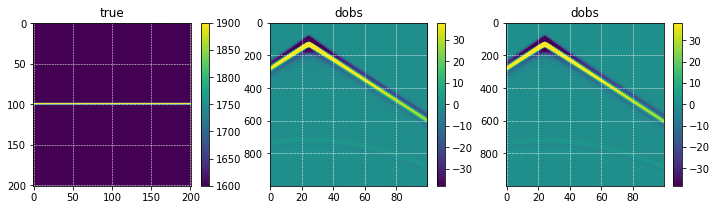

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read('true'),title='true')
plt.subplot(1,3,2); imshow(read_su('results_fwd/dsyn_Shot0001.su'), title='dobs',perc=98)
plt.subplot(1,3,3); imshow(read_su('results_fwd-REF/dsyn_Shot0001.su'), title='dobs',perc=98)

## FWI fieldsepa gradient

### homo

In [93]:
%%time

#!makevel nz=$nz nx=$nx v000=1500 > model
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup_default setup
!echo 'DIR_OUT   results_homo' >> setup

run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_FWIfieldsepa
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 35 Jun  3 12:19 ../../exe/FWI -> fwi_AC2nd_FDSG_O4_vp-rho_Wolfe_NLCG
 Git Commit: 3bf3ac9
 Git Branch: fieldsepa
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 06/03/2023
System time: 12:19:12
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_homo
 Output directory:results_homo/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x²,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   ->

 it----        1000
 fld_q minmax values:   0.00000000       0.00000000    
 fld_p minmax values:   0.00000000       0.00000000    
 fld_v minmax values: -0.238640055       2.01405597    
 fld_u minmax values: -0.270840973      0.217918023    
 it----         500
 fld_q minmax values:  -85715.7578       108613.367    
 fld_p minmax values:  -100823.000       90077.7344    
 fld_v minmax values:  -33.4156036       21.8100681    
 fld_u minmax values:  -20.6296577       33.8579712    
 Elapsed time to evolve field           4.27246094E-04
 Elapsed time to load boundary          1.16214752E-02
 Elapsed time to update field           10.5058289    
 Elapsed time to rm source              8.56399536E-04
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   1.10778809E-02
 Elapsed time to update adj field       10.4034176    
 Elapsed time to evolve adj field       6.23703003E-04
 Elapsed time to extract fields         0.00000000    
 Elapsed time to correlate       

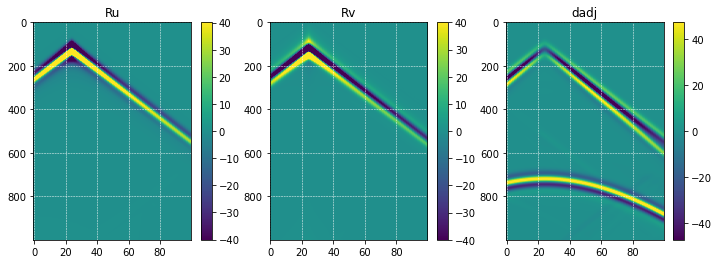

In [87]:
res='results_homo/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

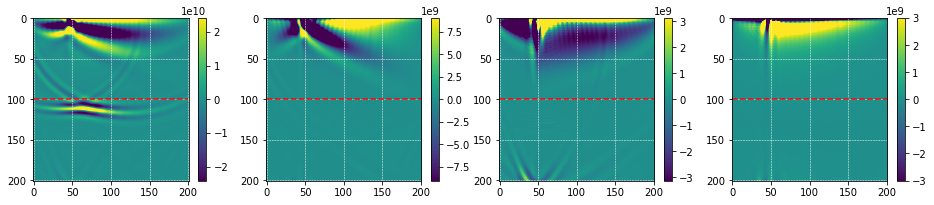

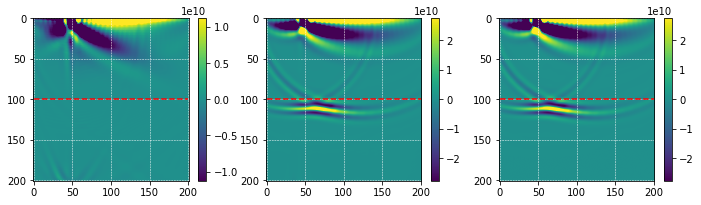

In [94]:
res='results_homo/'

term1=read(res+'U_star_D%gikpa') #migration isochrone
term2=read(res+'D_star_D%gikpa') #left rabbit ear
term3=read(res+'U_star_U%gikpa') #right rabbit ear
term4=read(res+'D_star_U%gikpa') #4th term

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term1,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term2,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term3,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(term4,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term2+term3      ,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term1+term2+term3,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term1+term2+term3+term4,perc=95); plt.plot([0,200],[100,100],'--r')

# plt.figure(figsize=(12,2))
# tr=read(res+'F0_star_E%rp_ddsp')[:,100]; plt.plot(tr/np.max(np.abs(tr)))
# tr=read(res+'dF_star_E%rp_ddsp')[:,100]; plt.plot(tr/np.max(np.abs(tr)))
# plt.grid(visible=True, axis='both', which='both')

### homo - nosepa

In [69]:
#!makevel nz=$nz nx=$nx v000=1500 > model
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup_default setup
!echo 'DIR_OUT   results_homo-nosepa' >> setup
!echo 'IF_1TERM  T' >> setup

run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_FWIfieldsepa
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 35 Jun  3 11:16 ../../exe/FWI -> fwi_AC2nd_FDSG_O4_vp-rho_Wolfe_NLCG
 Git Commit: 3bf3ac9
 Git Branch: fieldsepa
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 06/03/2023
System time: 11:19:25
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_homo-nosepa
 Output directory:results_homo-nosepa/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x²,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_

 it----         500
 fld_v minmax values:  -33.4587402       21.8571301    
 it----        1000
 fld_v minmax values: -0.239904776       1.96437085    
 Elapsed time to add source      3.20243835E-03
 Elapsed time to save boundary   1.79862976E-03
 Elapsed time to update field    2.64596701    
 Elapsed time to evolve field    1.79290771E-04
 Elapsed time to extract field   7.72523880E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_sfield%*  n1=249 perc=99
 xmovie < snap_sfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
At line 423 of file m_field.f90
Fortran runtime warning: An array temporary was created for argument 'datain' of procedure 'resampler'
At line 423 of file m_field.f90
Fortran runtime warning: An array temporary was created for argument 'datain' of procedure 'resampler'
At line 423 of file m_field.f90
Fortran runtime warning: An array temporary was created for argument 'datain' of procedure 'resampler'
At line 423 of file m_field.f90
Fortra

 ----  Solving adjoint eqn & xcorrelate  ----
 IF_1TERM : T
 it----        1000
 fld_p minmax values:   0.00000000       0.00000000    
 fld_u minmax values: -0.270841658      0.217915252    
 it----         500
 fld_p minmax values:  -100813.992       90087.8906    
 fld_u minmax values:  -20.6296577       33.8580017    
 Elapsed time to evolve field           2.59113312E-03
 Elapsed time to load boundary          4.36019897E-03
 Elapsed time to update field           2.42234612    
 Elapsed time to rm source              3.29780579E-03
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   1.02033615E-02
 Elapsed time to update adj field       2.39852428    
 Elapsed time to evolve adj field       6.21795654E-04
 Elapsed time to extract fields         0.00000000    
 Elapsed time to correlate              1.03217793    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip

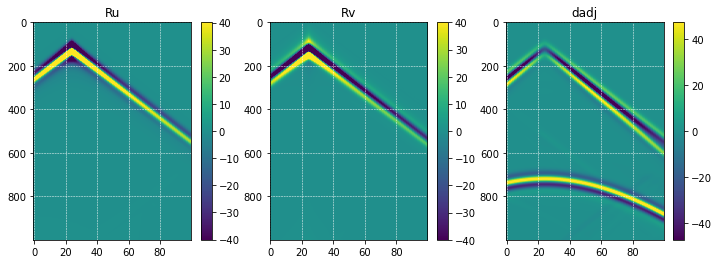

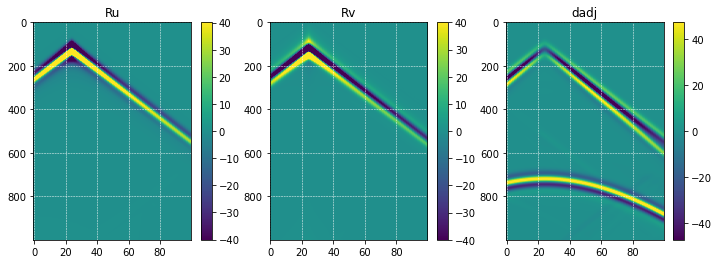

In [70]:
res='results_homo/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

res='results_homo-nosepa/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

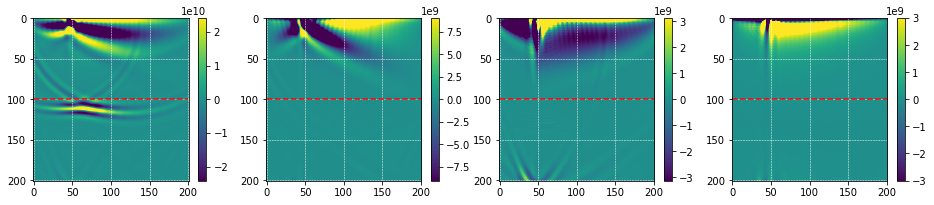

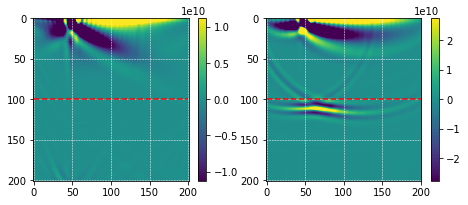

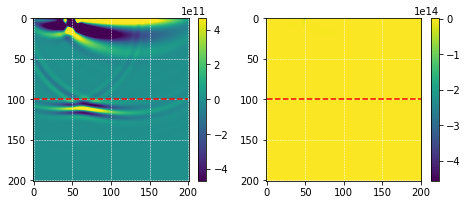

In [97]:
res='results_homo/'

term1=read(res+'U_star_D%gikpa') #migration isochrone
term2=read(res+'D_star_D%gikpa') #left rabbit ear
term3=read(res+'U_star_U%gikpa') #right rabbit ear
term4=read(res+'D_star_U%gikpa') #4th term

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term1,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term2,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term3,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(term4,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term2+term3      ,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term1+term2+term3,perc=95); plt.plot([0,200],[100,100],'--r')

(term1+term2+term3+term4).T.astype('float32').tofile('sum')

res='results_homo-nosepa/'
nosepa=read(res+'a_star_u%gikpa')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(nosepa,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(nosepa-term1-term2-term3-term4); plt.plot([0,200],[100,100],'--r')

### 2layer=1500/2000

In [98]:
model=np.zeros((nz,nx))
model[:,:]=1500.
model[int(nz/2)-1:int(nz/2)+1,:]=2000.
model.T.astype('float32').tofile('model')

!cp setup_default setup
!echo 'DIR_OUT   results_2layer' >> setup

run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_FWIfieldsepa
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 35 Jun  3 12:19 ../../exe/FWI -> fwi_AC2nd_FDSG_O4_vp-rho_Wolfe_NLCG
 Git Commit: 3bf3ac9
 Git Branch: fieldsepa
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 06/03/2023
System time: 12:24:47
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2layer
 Output directory:results_2layer/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x²,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
 

 it----         500
 fld_q minmax values:  -148343.969       112849.328    
 fld_p minmax values:  -134222.484       136577.297    
 fld_v minmax values:  -36.9056816       26.0578480    
 fld_u minmax values:  -22.2015152       38.6232605    
 Elapsed time to evolve field           6.66046143E-03
 Elapsed time to load boundary          1.34582520E-02
 Elapsed time to update field           11.8482132    
 Elapsed time to rm source              4.36782837E-03
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   1.52683258E-02
 Elapsed time to update adj field       11.3075829    
 Elapsed time to evolve adj field       4.55665588E-03
 Elapsed time to extract fields         0.00000000    
 Elapsed time to correlate             0.289100647    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201

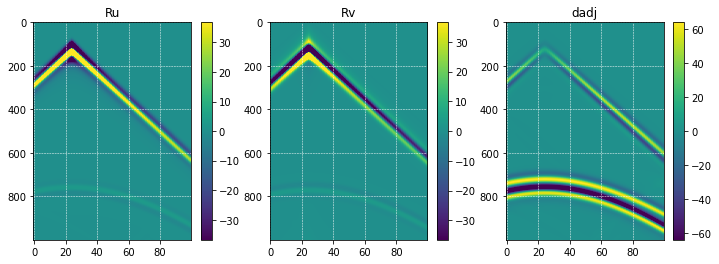

In [48]:
res='results_2layer/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

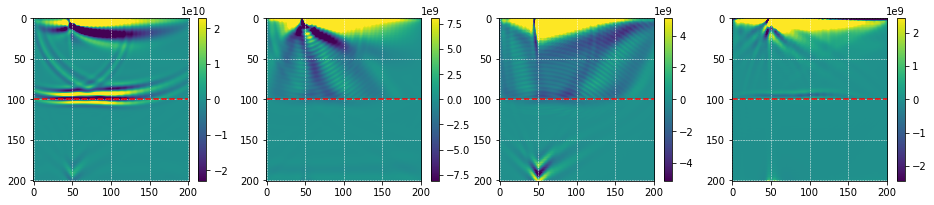

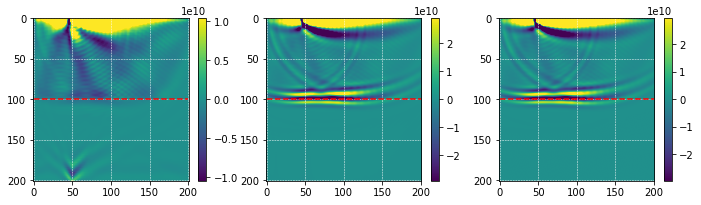

In [99]:
res='results_2layer/'

term1=read(res+'U_star_D%gikpa') #migration isochrone
term2=read(res+'D_star_D%gikpa') #left rabbit ear
term3=read(res+'U_star_U%gikpa') #right rabbit ear
term4=read(res+'D_star_U%gikpa') #4th term

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term1,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term2,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term3,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,4); imshow(term4,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term2+term3      ,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term1+term2+term3,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term1+term2+term3+term4,perc=95); plt.plot([0,200],[100,100],'--r')

# plt.figure(figsize=(12,2))
# tr=read(res+'F0_star_E%rp_ddsp')[:,100]; plt.plot(tr/np.max(np.abs(tr)))
# tr=read(res+'dF_star_E%rp_ddsp')[:,100]; plt.plot(tr/np.max(np.abs(tr)))
# plt.grid(visible=True, axis='both', which='both')

### 2layer=1500/2000 - nosepa

In [100]:
model=np.zeros((nz,nx))
model[:,:]=1500.
model[int(nz/2)-1:int(nz/2)+1,:]=2000.
model.T.astype('float32').tofile('model')

!cp setup_default setup
!echo 'DIR_OUT   results_2layer-nosepa' >> setup
!echo 'IF_1TERM  T' >> setup

run()

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_FWIfieldsepa
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 35 Jun  3 12:19 ../../exe/FWI -> fwi_AC2nd_FDSG_O4_vp-rho_Wolfe_NLCG
 Git Commit: 3bf3ac9
 Git Branch: fieldsepa
 Compiler: gfortran v11.3.0
 Version: 11.3.0
 Endianness:         1234
 System date: 06/03/2023
System time: 12:25:42
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2layer-nosepa
 Output directory:results_2layer-nosepa/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D Acoustic propagation
2nd-order Pressure formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x²,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_c

 it----         500
 fld_p minmax values:  -134222.484       136577.297    
 fld_u minmax values:  -22.2015152       38.6232605    
 Elapsed time to evolve field           1.57356262E-04
 Elapsed time to load boundary          1.07603073E-02
 Elapsed time to update field          0.972313881    
 Elapsed time to rm source              1.96933746E-04
 Elapsed time -----------------------
 Elapsed time to add adj & virtual src   1.20019913E-03
 Elapsed time to update adj field      0.887901306    
 Elapsed time to evolve adj field       1.82628632E-04
 Elapsed time to extract fields         0.00000000    
 Elapsed time to correlate             0.419004917    
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g
 ximage < snap_*  n1=201 perc=99
 xmovie < snap_*  n1=201 n2=201 clip=?e-?? loop=2 title=%g
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_

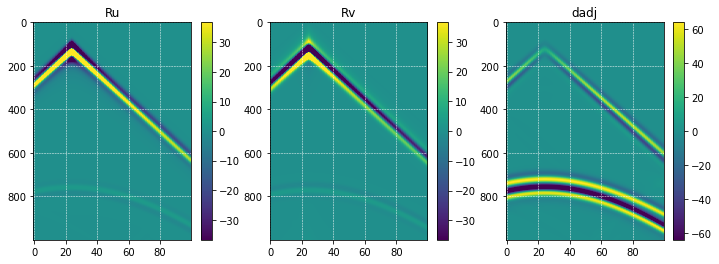

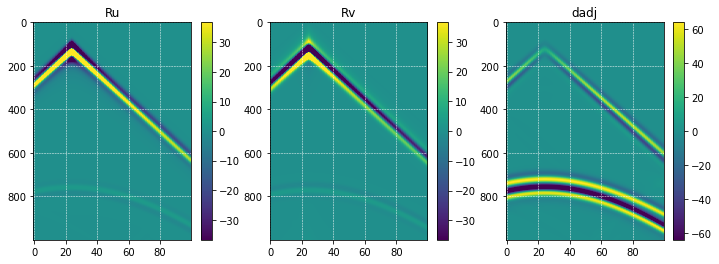

In [101]:
res='results_2layer/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

res='results_2layer-nosepa/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

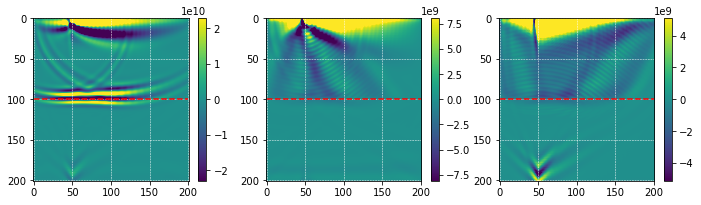

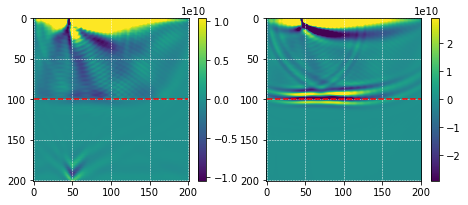

In [102]:
res='results_2layer/'

term1=read(res+'U_star_D%gikpa') #migration isochrone
term2=read(res+'D_star_D%gikpa') #left rabbit ear
term3=read(res+'U_star_U%gikpa') #right rabbit ear
term4=read(res+'D_star_U%gikpa') #4th term

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term1,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term2,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,3); imshow(term3,perc=95); plt.plot([0,200],[100,100],'--r')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(term2+term3      ,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(term1+term2+term3,perc=95); plt.plot([0,200],[100,100],'--r')

(term1+term2+term3).T.astype('float32').tofile('sum')

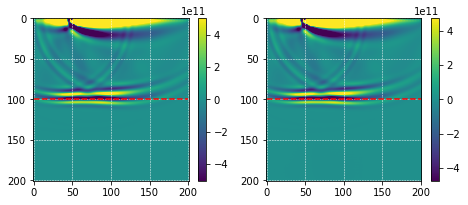

In [103]:
res='results_2layer-nosepa/'
allterms=read(res+'a_star_u%gikpa')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(allterms,perc=95); plt.plot([0,200],[100,100],'--r')
plt.subplot(1,4,2); imshow(allterms-term1-term2-term3,perc=95); plt.plot([0,200],[100,100],'--r')

## FWI iterate homo

### Term Weight = 1 5 5

In [106]:
#!makevel nz=$nz nx=$nx v000=1500 > model
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup_default setup
!echo 'DIR_OUT   results_homo_155' >> setup
!echo "GRADIENT_TERMS_WEIGHT  '1 5 5'" >> setup
!echo "SMOOTHING  none" >> setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

!mkdir results_homo_155
run(out='results_homo_155/out')

mv: cannot stat 'results_homo_155/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_155/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_155/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_155/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_155/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_155/updated_wavelet.su

In [107]:
!cat results_homo_155/optimization.log

 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =9.61635320E-04
     Initial gradient L1norm (║g0║₁)  =8.0802E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 8.5513E+00 100.000  100.000     -9.26E-01
            1      2  1.00E+00       8.2029E+00                      -8.97E-01   T F
            2      3  1.00E+01       6.0137E+00                      -3.82E-01   T T
     1             3                 6.0137E+00  70.325   91.337     -4.39E-01

In [109]:
!grep Angle -a results_homo_155/out

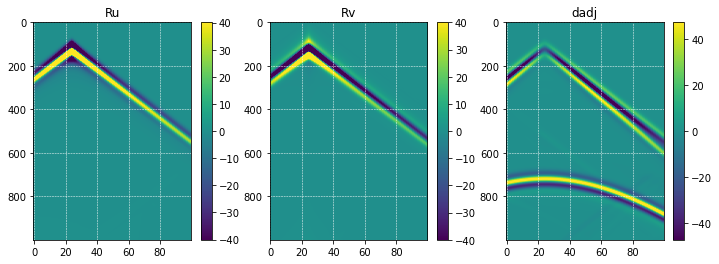

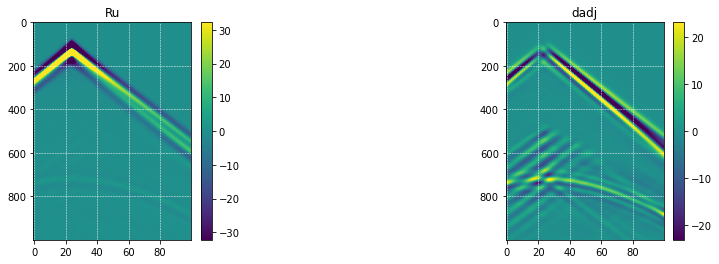

In [112]:
res='results_homo/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

res='results_homo_155/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Iter9_Shot0001.su'), title='Ru',perc=98)
#plt.subplot(1,3,2); imshow(read_su(res+'Rv_Iter9_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Iter9_Shot0001.su'), title='dadj',perc=98)

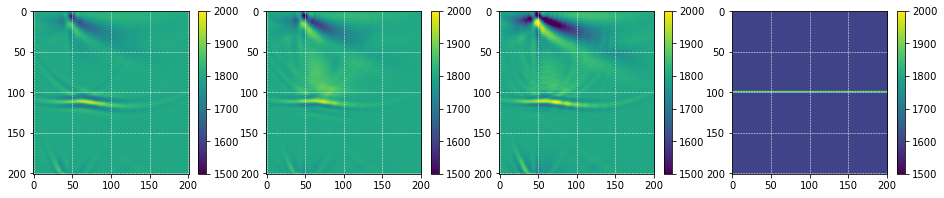

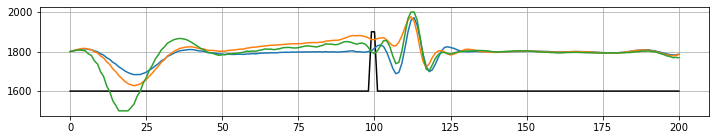

In [121]:
res='results_homo_155/'

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(read(res+'model_Iter1'),clip=(1500,2000))
plt.subplot(1,4,2); imshow(read(res+'model_Iter2'),clip=(1500,2000))
plt.subplot(1,4,3); imshow(read(res+'model_final'),clip=(1500,2000))
plt.subplot(1,4,4); imshow(read('true'           ),clip=(1500,2000))

plt.figure(figsize=(12,2))
plt.plot(read('true'           )[:,75],'k')
plt.plot(read(res+'model_Iter1')[:,75])
plt.plot(read(res+'model_Iter2')[:,75])
plt.plot(read(res+'model_final')[:,75])
plt.grid(visible=True, axis='both', which='both')

### Term Weight = 1 1 1

In [116]:
#!makevel nz=$nz nx=$nx v000=1500 > model
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup_default setup
!echo 'DIR_OUT   results_homo_111' >> setup
!echo "GRADIENT_TERMS_WEIGHT  '1 1 1'" >> setup
!echo "SMOOTHING  none" >> setup
!echo "IF_COMPUTE_ANGLE  T" >>setup
!echo 'JOB   optimization' >> setup
!echo 'SNAPSHOT      none' >> setup

!mkdir results_homo_111
run(out='results_homo_111/out')

mv: cannot stat 'results_homo_111/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_111/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_111/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_111/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/updated_wavelet.su': No such file or directory
mv: cannot stat 'results_homo_111/dsyn_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/RE_Shot0001.su': No such file or directory
mv: cannot stat 'results_homo_111/updated_wavelet.su

In [117]:
!cat results_homo_111/optimization.log

 **********************************************************************
    NONLINEAR CONJUGATE GRADIENT ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =   10
     Max linesearches allowed =   12
     Max gradients allowed    =   40
     Linesearch scaler        =2.19162926E-03
     Initial gradient L1norm (║g0║₁)  =8.0803E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.9489E+01 100.000  100.000     -8.25E-01
            1      2  1.00E+00       1.8728E+01                      -7.56E-01   T F
            2      3  1.00E+01       1.4976E+01                      -8.56E-02   T T
     1             3                 1.4976E+01  76.842  110.201     -7.12E-01

In [118]:
!grep Angle -a results_homo_111/out

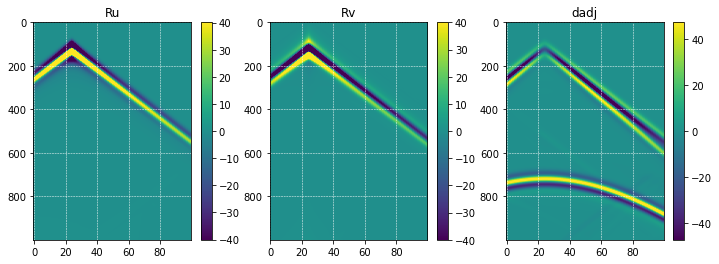

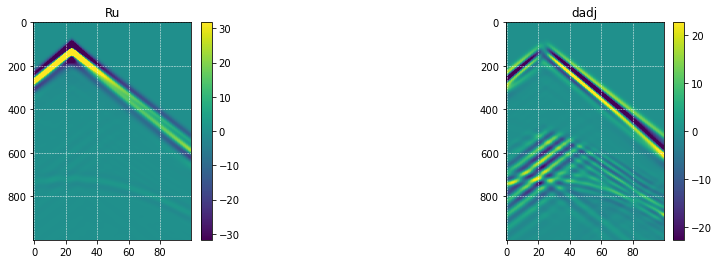

In [119]:
res='results_homo/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Shot0001.su'), title='Ru',perc=98)
plt.subplot(1,3,2); imshow(read_su(res+'Rv_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Shot0001.su'), title='dadj',perc=98)

res='results_homo_111/'

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); imshow(read_su(res+'Ru_Iter9_Shot0001.su'), title='Ru',perc=98)
#plt.subplot(1,3,2); imshow(read_su(res+'Rv_Iter9_Shot0001.su'), title='Rv',perc=98)
plt.subplot(1,3,3); imshow(read_su(res+'dadj_Iter9_Shot0001.su'), title='dadj',perc=98)

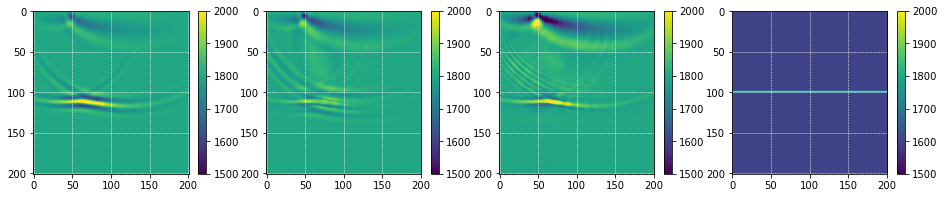

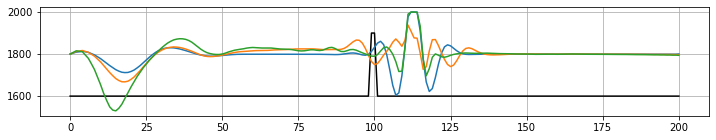

In [122]:
res='results_homo_111/'

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(read(res+'model_Iter1'),clip=(1500,2000))
plt.subplot(1,4,2); imshow(read(res+'model_Iter2'),clip=(1500,2000))
plt.subplot(1,4,3); imshow(read(res+'model_final'),clip=(1500,2000))
plt.subplot(1,4,4); imshow(read('true'           ),clip=(1500,2000))

plt.figure(figsize=(12,2))
plt.plot(read('true'           )[:,75],'k')
plt.plot(read(res+'model_Iter1')[:,75])
plt.plot(read(res+'model_Iter2')[:,75])
plt.plot(read(res+'model_final')[:,75])
plt.grid(visible=True, axis='both', which='both')